In [ ]:
pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.8 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from art import config
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.estimators.certification.randomized_smoothing import TensorFlowV2RandomizedSmoothing
from art.utils import load_dataset, get_file, compute_accuracy

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

nb_classes = 10
input_shape = x_train.shape[1:]

num_samples_test = 250
x_test = x_test[0:num_samples_test].astype(np.float32)
y_test = y_test[0:num_samples_test]

x_train = x_train.astype(np.float32)

In [ ]:
# Create convolutional neural network model
def get_model(input_shape, min_, max_):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [ ]:
nb_epochs = 40
batch_size = 32
sample_size = 100
alpha = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(model, images, labels):        
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

## Construct and train a convolutional neural network in standard (non-smoothed/baseline) classifier


In [ ]:
classifier = TensorFlowV2Classifier(model=get_model(input_shape, min_, max_),
                                    nb_classes=nb_classes,
                                    input_shape=input_shape,
                                    loss_object=loss_object,
                                    train_step=train_step,
                                    channels_first=False,
                                    clip_values=(min_, max_))

classifier.fit(x_train, y_train, nb_epochs=40, batch_size=32)

# Create and train smoothed classifier, $\sigma = 0.25$

In [ ]:
sigma_1 = 0.5

classifier_rs_1 = TensorFlowV2RandomizedSmoothing(model=classifier.model,
                                                  nb_classes=nb_classes,
                                                  input_shape=input_shape,
                                                  loss_object=loss_object,
                                                  train_step=train_step,
                                                  channels_first=False,
                                                  clip_values=(min_, max_),
                                                  sample_size=sample_size,
                                                  scale=sigma_1,
                                                  alpha=alpha)

classifier_rs_1.fit(x_train, y_train, nb_epochs=40, batch_size=50)

100%|██████████| 40/40 [21:44<00:00, 32.61s/it]


In [ ]:
sigma_2 = 0.25

classifier_rs_2 = TensorFlowV2RandomizedSmoothing(model=classifier.model,
                                                 nb_classes=nb_classes,
                                                 input_shape=input_shape,
                                                 loss_object=loss_object,
                                                 train_step=train_step,
                                                 channels_first=False,
                                                 clip_values=(min_, max_),
                                                 sample_size=sample_size,
                                                 scale=sigma_2,
                                                 alpha=alpha)

classifier_rs_2.fit(x_train, y_train, nb_epochs=40, batch_size=50)

100%|██████████| 40/40 [21:42<00:00, 32.55s/it]


# Prediction

Let's compare prediction of randomized smoothed models to original model

In [ ]:
x_preds = classifier.predict(x_test)
x_preds_rs_1 = classifier_rs_1.predict(x_test)
x_preds_rs_2 = classifier_rs_2.predict(x_test)

acc, cov = compute_accuracy(x_preds, y_test)
acc_rs_1, cov_rs_1 = compute_accuracy(x_preds_rs_1, y_test)
acc_rs_2, cov_rs_2 = compute_accuracy(x_preds_rs_2, y_test)

print("\nOriginal test data:")
print("Original Classifier")
print("Accuracy: {}".format(acc))
print("Coverage: {}".format(cov))

print("\nSmoothed Classifier, sigma=" + str(sigma_0))
print("Accuracy: {}".format(acc_rs_1))
print("Coverage: {}".format(cov_rs_1))

print("\nSmoothed Classifier, sigma=" + str(sigma_1))
print("Accuracy: {}".format(acc_rs_2))
print("Coverage: {}".format(cov_rs_2))

Randomized smoothing:   0%|          | 0/250 [00:00<?, ?it/s]

Randomized smoothing:   0%|          | 0/250 [00:00<?, ?it/s]


Original test data:
Original Classifier
Accuracy: 1.0
Coverage: 1.0

Smoothed Classifier, sigma=0.5
Accuracy: 1.0
Coverage: 0.976

Smoothed Classifier, sigma=0.25
Accuracy: 1.0
Coverage: 1.0


In [ ]:
sigma_0 = 0.0

classifier_rs_0 = TensorFlowV2RandomizedSmoothing(model=classifier.model,
                                                 nb_classes=nb_classes,
                                                 input_shape=input_shape,
                                                 loss_object=loss_object,
                                                 train_step=train_step,
                                                 channels_first=False,
                                                 clip_values=(min_, max_),
                                                 sample_size=sample_size,
                                                 scale=sigma_0,
                                                 alpha=alpha)

classifier_rs_0.fit(x_train, y_train, nb_epochs=40, batch_size=50)

100%|██████████| 40/40 [21:29<00:00, 32.24s/it]


# Certification of Accuracy and L2-Radius

## Calculate certification accuracy for a given radius

In [ ]:
def getCertAcc(radius, pred, y_test):

    rad_list = np.linspace(0, 2.25, 201)
    cert_acc = []
    num_cert = len(radius)
    
    for r in rad_list:
        rad_idx = np.where(radius >= r)[0]
        y_test_subset = y_test[rad_idx]
        cert_acc.append(np.sum(pred[rad_idx] == np.argmax(y_test_subset, axis=1)) / num_cert)
        
    return cert_acc

## Compute certification

In [ ]:
# prediction_0, radius_0 = classifier.certify(x_test, n=500)
prediction_1, radius_1 = classifier_rs_1.certify(x_test, n=500)
prediction_2, radius_2 = classifier_rs_2.certify(x_test, n=500)

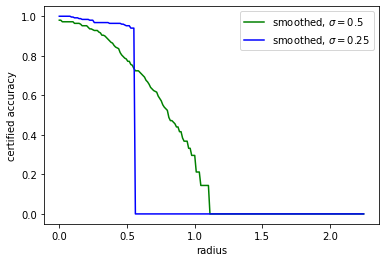

In [ ]:
# Plot certification accuracy w.r.t. to radius
rad_list = np.linspace(0, 2.25, 201)
# plt.plot(rad_list, getCertAcc(radius_0, prediction_0, y_test), 'r-', label='original')
plt.plot(rad_list, getCertAcc(radius_1, prediction_1, y_test), '-', color='green',
         label='smoothed, $\sigma=$' + str(sigma_0))
plt.plot(rad_list, getCertAcc(radius_2, prediction_2, y_test), '-', color='blue',
         label='smoothed, $\sigma=$' + str(sigma_1))
plt.xlabel('radius')
plt.ylabel('certified accuracy')
plt.legend()
plt.show()